In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-7 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse
theta = 0.5 # fraction hillslope that enters as coarse
# treat as same!!! Point is what fraction becomes coarse
# so just be sure to change these together

kqs = 0.051 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma, theta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 40
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * gamma
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * theta)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 1000000

test_run = [x, dx, x_node, 
            K, beta, gamma, theta,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

40000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

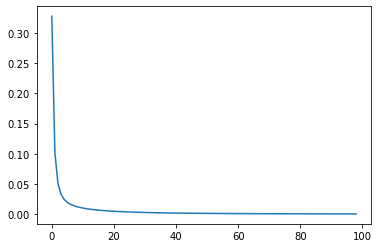

In [8]:
plt.plot(S)

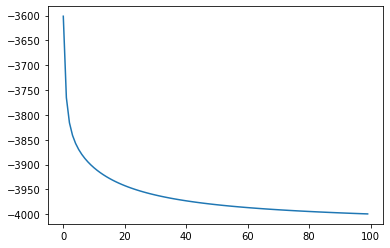

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0004364644046208923

In [11]:
eta

array([-3601.3630527 , -3765.19522991, -3815.84052764, -3841.11569225,
       -3857.449252  , -3869.59507827, -3879.35366497, -3887.55947144,
       -3894.660774  , -3900.92605152, -3906.52983511, -3911.59298157,
       -3916.20342894, -3920.42772871, -3924.31786013, -3927.91546936,
       -3931.25462426, -3934.3636734 , -3937.26654225, -3939.98366329,
       -3942.5326606 , -3944.92886504, -3947.18570978, -3949.31503933,
       -3951.32735479, -3953.23201122, -3955.03737844, -3956.75097343,
       -3958.37957058, -3959.92929412, -3961.40569629, -3962.81382401,
       -3964.15827594, -3965.44325168, -3966.67259448, -3967.84982835,
       -3968.97819053, -3970.06066   , -3971.09998264, -3972.09869335,
       -3973.05913582, -3973.98347999, -3974.87373769, -3975.73177657,
       -3976.55933262, -3977.35802139, -3978.1293481 , -3978.87471672,
       -3979.59543823, -3980.29273806, -3980.96776281, -3981.6215864 ,
       -3982.25521561, -3982.86959521, -3983.4656125 , -3984.04410161,
      

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([3.98036947e+02, 2.34204770e+02, 1.83559472e+02, 1.58284308e+02,
       1.41950748e+02, 1.29804922e+02, 1.20046335e+02, 1.11840528e+02,
       1.04739226e+02, 9.84739484e+01, 9.28701648e+01, 8.78070184e+01,
       8.31965710e+01, 7.89722712e+01, 7.50821398e+01, 7.14845306e+01,
       6.81453757e+01, 6.50363265e+01, 6.21334577e+01, 5.94163366e+01,
       5.68673393e+01, 5.44711349e+01, 5.22142902e+01, 5.00849606e+01,
       4.80726451e+01, 4.61679887e+01, 4.43626215e+01, 4.26490265e+01,
       4.10204294e+01, 3.94707058e+01, 3.79943036e+01, 3.65861759e+01,
       3.52417240e+01, 3.39567483e+01, 3.27274055e+01, 3.15501716e+01,
       3.04218094e+01, 2.93393399e+01, 2.83000173e+01, 2.73013066e+01,
       2.63408641e+01, 2.54165199e+01, 2.45262622e+01, 2.36682234e+01,
       2.28406673e+01, 2.20419785e+01, 2.12706518e+01, 2.05252832e+01,
       1.98045617e+01, 1.91072619e+01, 1.84322371e+01, 1.77784135e+01,
       1.71447843e+01, 1.65304047e+01, 1.59343874e+01, 1.53558983e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_11.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_11.csv', alpha, delimiter = ',')